# EOS 1 image analysis Python code walk-through

- This is to explain how the image analysis works for the EOS 1. Python version 2.7.15 (Anaconda 64-bit)

- If you are using EOS 1, you can use this code for image analysis after reading through this notebook and understand how it works.

- Alternatively, you can also use the ImgAna_minimum.py script. 

- Needless to say, this Python code is not optimized for speed. 

- Feel free to share and modify.

## - 00 - import libraries: matplolib for handling images; numpy for matrix manipulation

In [3]:
import matplotlib.pyplot as pp
import matplotlib.image as mpimg
import numpy as np
import warnings
import math

## - 01 - function for displaying images and making figures

In [4]:
# Input: x_img=numpy_array_of_image, marker=marker_of_1D_plot, x_max=max_value
def fig_out( x_img, fig_dpi=120, marker="k.-", x_max=510 ):
    pp.figure( dpi=fig_dpi )
    pp.style.use( "seaborn-dark" )
    if x_img.ndim == 1:
        pp.style.use( "seaborn-darkgrid" )
        pp.plot( x_img, marker )
    elif x_img.ndim == 2:
        if len( x_img[0] ) == 3:
            pp.style.use( "seaborn-darkgrid" )
            pp.plot( x_img[:,0], 'r-' )
            pp.plot( x_img[:,1], 'g-' )
            pp.plot( x_img[:,2], 'b-' )
        else:
            pp.imshow( x_img, cmap="gray", vmin=0, vmax=x_max )
            pp.colorbar()
    elif x_img.ndim == 3:
        x_img = x_img.astype( int )
        pp.imshow( x_img )
    else:
        print ("Input not recognized.")
        ## Not raise an error because no other functions not depend on output of this function.

In Python, an image is represented by a 3D-numpy array.
For example, a simple image of:
red, green, blue, black
cyan, purple, yellow, white
can be written as the following:

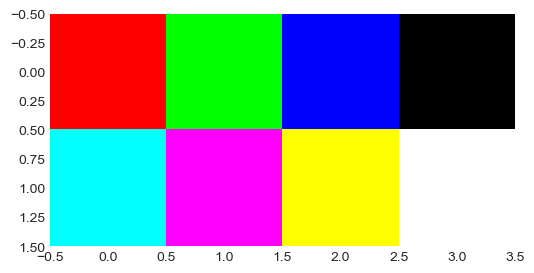

In [5]:
x = np.array([[[255,0,0], [0,255,0], [0,0,255], [0,0,0]],
              [[0,255,255], [255,0,255], [255,255,0], [255,255,255]]])
fig_out( x, fig_dpi=100 )

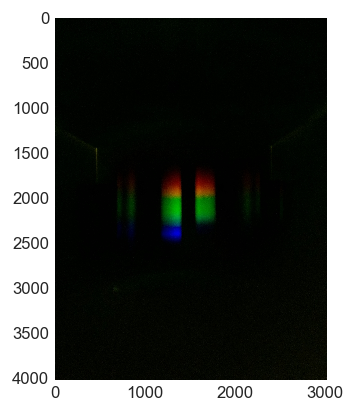

In [7]:
# example of an image from EOS 1
img_file = "EOS_imgs/IMG_3910.JPG"#1_1IMG_3919.jpg"
xi = pp.imread( img_file )
# xi = np.rot90(xi,k=3)
xi = centeredCrop(xi)
fig_out( xi )

## - 02 - function for read in image and then calculating the color_diff_sum heat map

In [8]:
# Input: x_img=input_image_as_numpy_array, fo=full_output
def cal_heatmap( x_img, fo=False ):
    xf = x_img.astype( float )
    if xf.ndim == 2:
        cds  = abs(xf[:,0]-xf[:,1]) 
        cds += abs(xf[:,0]-xf[:,2]) 
        cds += abs(xf[:,1]-xf[:,2])
    elif xf.ndim == 3:
        cds  = abs(xf[:,:,0]-xf[:,:,1]) 
        cds += abs(xf[:,:,0]-xf[:,:,2]) 
        cds += abs(xf[:,:,1]-xf[:,:,2])
    else:
        raise ValueError( "Image array not recoginzed." ) 
    
    if fo == True:
        fig_out( cds )
    else:
        pass
    
    return cds

This color_diff_sum metric is used to rank the colorfulness of the pixels.
It highlights bright colors while suppresses white and black, as demonstrated below:

In [9]:
cal_heatmap( x )

array([[510., 510., 510.,   0.],
       [510., 510., 510.,   0.]])

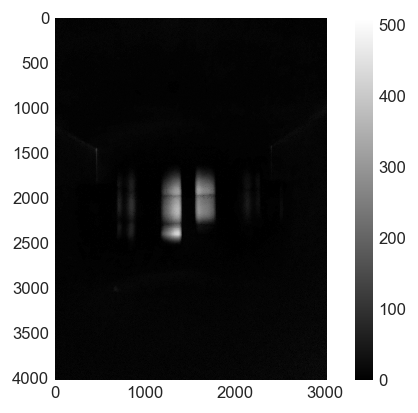

In [10]:
# try out the heat map function on the example image
hm = cal_heatmap( xi, True )

## - 03 - function for finding the reference spectrum

In [11]:
# Input: x_hm=heat_map_as_numpy_array, fo=full_output, n=threshold_as_ratio_of_peak
# Input: pf_check=profile_check, rt_check=rotation_check 
def find_ref( x_hm, fo=False, n=0.25, pf_check=True, rt_check=False ):
    n = float( n )
    if n<0.1 or n>0.9:
        n = 0.25    # n should be between 0.1 and 0.9, otherwise set to 0.25
    else:
        pass
    
    h, w = x_hm.shape
    if h<w and pf_check==True:
        warnings.warn( "Input spectra image appears to be landscape." )
        proceed = 'y'; #raw_input( "Continue? (y/N): " )
        if proceed=='y' or proceed=='Y':
            pass
        else:
            raise RuntimeError( "Program terminated by user." )
    else:
        pass
    
    x0 = x_hm.mean( axis=0 )
    x0thres = np.argwhere( x0 > x0.max()*n ).flatten()
    x0diff  = x0thres[1:] - x0thres[:-1]
    x0gap   = np.where( x0diff > 2. )[0].flatten()
    if len( x0gap )==0:
        if rt_check==True:
            fig_out( x_hm )
            rotate = raw_input( "Rotate image? (y/N): " )
            if rotate=='y' or rotate=='Y':
                raise RuntimeError( "Rotate image then restart program." )
            else:
                pass
        else:
            pass
        l_edge, r_edge = x0thres[0], x0thres[-1]
    else:
        d_to_center = []
        for i in x0gap:
            d_to_center.append( abs( w/2. - x0thres[i:i+2].mean() ) )
        d_min = np.argmin( d_to_center )
        if d_min==0:
            l_edge, r_edge = x0thres[0], x0thres[ x0gap[0] ]
        else:
            l_edge, r_edge = x0thres[ x0gap[d_min-1]+1 ], x0thres[ x0gap[d_min] ]
    
    x_hm_ref = x_hm[ :, l_edge:r_edge+1 ]
    x1 = x_hm_ref.mean( axis=1 )
    x1thres = np.argwhere( x1 > x1.max()*n ).flatten()
    t_edge, b_edge = x1thres[0], x1thres[-1]
    tblr_edge = ( t_edge, b_edge, l_edge, r_edge )
    
    if fo==True:
        fig_out( x0, fig_dpi=120 )
        fig_out( x1, fig_dpi=120 )
    else:
        pass
    
    return tblr_edge

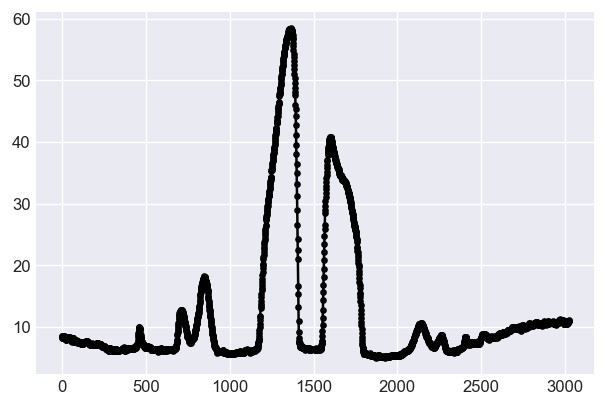

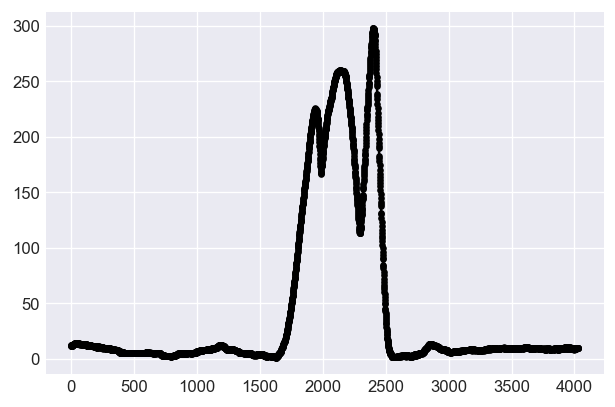

In [12]:
# try out the reference spectrum function
top, btm, lft, rgt = find_ref( hm, True )

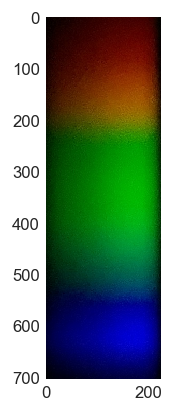

In [13]:
# check the reference spectrum found
fig_out( xi[top:btm+1, lft:rgt+1, :] )

## - 04 - function for checking the alignment (omitted) 

In [14]:
def align_check():
    return 0

## - 05 - function for normalizing the sample spectrum 

In [40]:
# Input: x_img=input_image_as_numpy_array, fo=full_output
# Input: bpeak_chl=channel_used_to_find_blue_peak 
# Input: trim_edge=trim_edge_of_image, trim_margin=trim_margin_of_spectra
# Input: gapcal=method_for_calculating_gap_between_reference_and_sample
def norm_sam( x_img, fo=False, bpeak_chl='r', trim_edge=False, trim_margin=True, gapcal='p' ):
    h, w, d = x_img.shape 
    if trim_edge == True:
        x_img = x_img[h/4:h*3/4, w/4:w*3/4, :]
    else:
        pass
    x_img = x_img.astype( float )
    hm = cal_heatmap( x_img )
    t_edge, b_edge, l_edge, r_edge = find_ref( hm )
        
    ref_wid = r_edge - l_edge
    if trim_margin == True:
        mrg = int( ref_wid/10. )
    else:
        mrg = 0
    half_hgt = int( (b_edge - t_edge)/2. )
    x_ref = x_img[ t_edge:b_edge, l_edge+mrg:r_edge-mrg, : ]
    y_ref = x_ref.mean( axis=1 )
    
    if bpeak_chl == 'r':
        peak_r = y_ref[:half_hgt,0].argmax()
        peak_b = y_ref[half_hgt:,0].argmax()+half_hgt
    else:
        peak_rgb = y_ref.argmax( axis=0 )
        peak_r, peak_b = peak_rgb[[0,2]]

    if gapcal == 'w':
        gap = int( ref_wid*0.901 )
    else:
        gap = int( ( peak_b-peak_r )*0.368 )
    x_sam = x_img[ t_edge:b_edge, r_edge+gap+mrg:r_edge+gap+ref_wid-mrg, : ]
    y_sam = x_sam.mean( axis=1 )
    max_rgb = y_ref.max( axis=0 )

    peak_px = np.array([peak_r, peak_b]).flatten()
    peak_nm = np.array([610.65, 449.1])
    f = np.polyfit( peak_px, peak_nm, 1 )
    wavelength = np.arange(b_edge-t_edge)*f[0]+f[1]
    if trim_edge == True:
        t_edge, b_edge = t_edge+h/4, b_edge+h/4
        l_edge, r_edge = l_edge+w/4, r_edge+w/4
        peak_r, peak_b = peak_r+t_edge, peak_b+t_edge
    else:
        pass
    
    y_sam_norm_r = y_sam[:, 0]/max_rgb[0]
    y_sam_norm_g = y_sam[:, 1]/max_rgb[1]
    y_sam_norm_b = y_sam[:, 2]/max_rgb[2]
    y_sam_norm = np.dstack((y_sam_norm_r, y_sam_norm_g, y_sam_norm_b))[0]

    if fo == True:
        return ((wavelength, y_sam_norm), (y_ref, y_sam), 
                (t_edge, b_edge, l_edge, r_edge, peak_r, peak_b, gapcal))
    else:
        return (wavelength, y_sam_norm, y_ref)

In [16]:
# try out the sample spectrum function
full_result = norm_sam( xi, True )
wv, sam_norm = full_result[0]
ref_raw, sam_raw = full_result[1]
other_result = full_result[2]

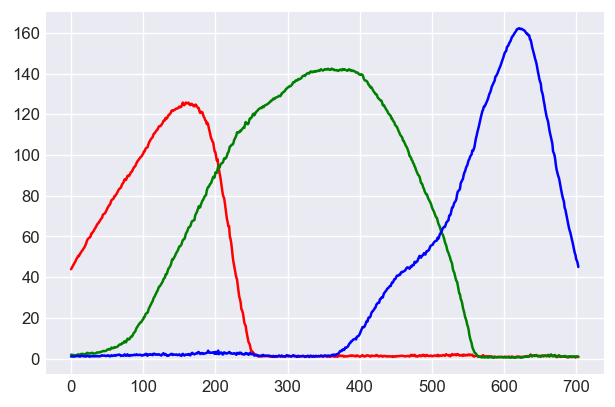

In [17]:
# check the reference spectrum (averaged)
fig_out( ref_raw, fig_dpi=120 )

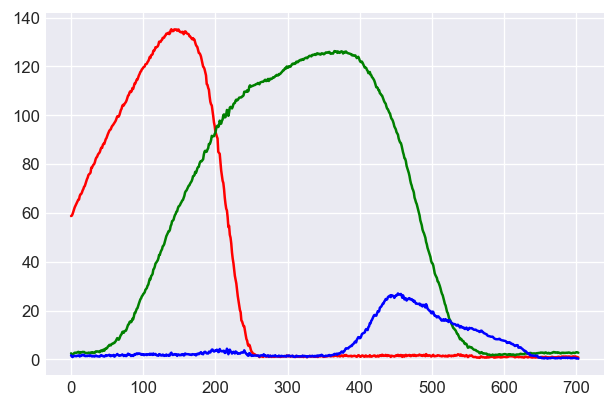

In [18]:
# check the sample spectrum (averaged) before normalization
fig_out( sam_raw, fig_dpi=120 )

Text(0,0.5,'normalized intensity')

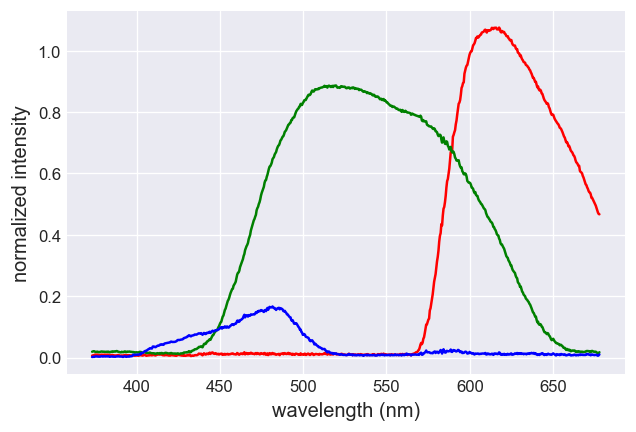

In [19]:
# check the normalized sample spectrum (averaged)
pp.figure( dpi=120 )
pp.style.use( "seaborn-darkgrid" )
pp.plot( wv, sam_norm[:,0], 'r-' )
pp.plot( wv, sam_norm[:,1], 'g-' )
pp.plot( wv, sam_norm[:,2], 'b-' )
pp.xlabel( "wavelength (nm)", size=12 )
pp.ylabel( "normalized intensity", size=12 )

## - 06 - function for calculating average intensity over a narrow band

In [42]:
# Input: ifn=image_file_name, ch=color_channel
# Input: wlc=wavelength_range_center, wlhs=wavelength_range_half_span
# Input: tm=trim_edge, gp=method_for_gap_calculation, fo=full_output
def cal_I( ifn, ch='g', wlc=535., wlhs=5., te=False, gp='p', fo=False ):
    wl_low, wl_high = wlc-wlhs, wlc+wlhs
#     print (ifn)
    xi = mpimg.imread(ifn)
#     print(xi.size)
    if xi.size > 6000000:
#         fig, ax = pp.subplots()
#         im = ax.imshow(xi)
#         pp.show()
        xi = np.rot90(xi,k=3)
        xi = centeredCrop(xi)
#         fig_out( xi )
        
    wl_arr, sam_norm, y_ref = norm_sam( xi, trim_edge=te, gapcal=gp )
    
    if ch=='r' or ch=='R':
        y_arr = sam_norm[:,0]
    elif ch=='g' or ch=='G':
        y_arr = sam_norm[:,1]
    elif ch=='b' or ch=='B':
        y_arr = sam_norm[:,2]
    else:
        raise ValueError( "Color channel should be 'r', 'g', or 'b'." )
    
  
    arg_low = np.where( wl_arr < wl_high )[0][0]
    arg_high = np.where( wl_arr > wl_low )[0][-1]
    
    
      #sending reference signal at the wavelength
    if ch=='r' or ch=='R':
        ref = y_ref[:,0]
    elif ch=='g' or ch=='G':
        ref = y_ref[:,1]
    elif ch=='b' or ch=='B':
        ref = y_ref[:,2]
    else:
        raise ValueError( "Color channel should be 'r', 'g', or 'b'." )
    I_sum_ref = ref[arg_low:arg_high+1].sum()
    I_ave_ref = I_sum_ref/(arg_high-arg_low+1)
    
    
    I_sum = y_arr[arg_low:arg_high+1].sum()
    I_ave = I_sum/(arg_high-arg_low+1)
    
    if fo == True:
        print (y_arr[arg_low:arg_high+1])
        pp.figure( dpi=120 )
        pp.style.use( "seaborn-darkgrid" )
        pp.plot( wl_arr, y_arr, 'k.-' )
        pp.xlabel( "wavelength (nm)", size=12 )
        pp.ylabel( "normalized intensity", size=12 )
    else:
        pass
    return I_ave, I_ave_ref

[0.83650659 0.83952401 0.84143646 0.84203145 0.84190395 0.84067148
 0.84283893 0.8441564  0.84628134 0.84725882 0.84713132 0.84560136
 0.84929877 0.85048874 0.84963876 0.85010625 0.8518912  0.84946876
 0.85252869 0.85503612 0.8519762  0.85269868 0.85278368 0.85074373]


0.8471667374982292

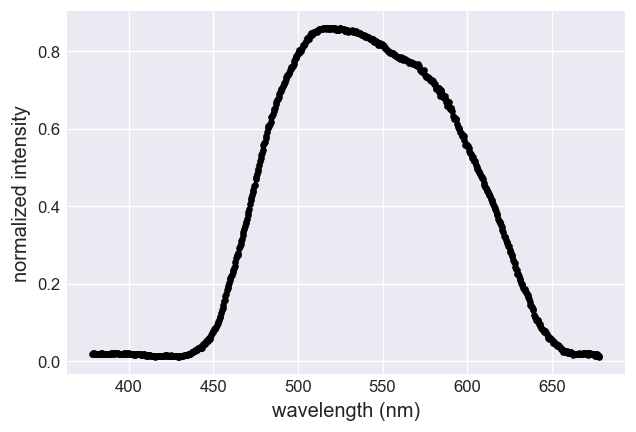

In [25]:
# try out the average intensity function
cal_I( img_file, fo=True )

## - 07 - function for calculating nitrate concentration

In [26]:
# Input: image_file=path_and_name_of_image_file, wl=center_wavelength
def test_N( image_file, wl=530., k=-7.8279, b=-0.14917 ):
    I = cal_I(image_file, wlc=wl)
    lgI = np.log10(I)
    nc = lgI*k + b
    print ("Nitrate Concentration: "+str(round(nc, 2))+" mg/L")
    return nc

In [27]:
# from PIL import Image

In [28]:
def centeredCrop(img, new_height=1000, new_width= 600):
    width =  np.size(img,1)
    height =  np.size(img,0)
    
    left = int(np.ceil((width - new_width)/2.))
    top = int(np.ceil((height - new_height)/2.))
    right = int(width - np.floor((width - new_width) / 2.))
    bottom = int(np.floor((height + new_height)/2.))
    cImg = img[top:bottom, left:right]
    return cImg

In [44]:
# Input: image_file=path_and_name_of_image_file, wl=center_wavelength
def getAbs_Intensity( image_file, wl=530., k=-7.8279, b=-0.14917 ):
    I, I_ave_ref = cal_I(image_file, wlc=wl)
    lgI = np.log10(I)* -1
    nc = lgI*k + b
    nc = (round(nc, 2))
    return nc,I,lgI, I_ave_ref

In [30]:
import os
from PIL import Image
from PIL.ExifTags import TAGS
import re

In [54]:
# try out the nitrate concentration function

runNames =['1mgrun1','1mgrun2',
'1mgrun3',
'1mgrun4',
'1mgrun5',
'5mgrun1',
'5mgrun2',
'5mgrun3',
'5mgrun4',
'5mgrun5',
'10mgrun1attempt2',
'10mgrun2',
'10mgrun3',
'10mgrun4',
'10mgrun5']

for run in runNames:
    dash ='/'
    recordFile = open("results_"+run+".csv",'w')
    recordFile.write("ImagePath,Nconcentraion,Reference_Intensity,Intensityratio,Absorbance,time, ExposureTime, FNumber, ShutterSpeedValue\n")
    files = [f for f in os.listdir('EOS_imgs/'+run+dash) if f.endswith(".JPG")]
    for file in files:
        img_path = "EOS_imgs/"+run+dash+file
        print(img_path)
        nc,I,lgI, I_ave_ref = getAbs_Intensity(img_path)

        i = Image.open(img_path)
        time =  i._getexif()[36867]
        d = time.split(" ")
        d1 = re.sub(":","-",d[0])
        dt = d1 + " " +d[1]
        
        ShutterSpeedValue= i._getexif()[37377]
        ApertureValue = i._getexif()[37378]
        BrightnessValue = i._getexif()[37379]
        ExposureBiasValue = i._getexif()[37380]
        MeteringMode = i._getexif()[37383]
        Flash = i._getexif()[37385]
        FocalLength = i._getexif()[37386]
        WhiteBalance = i._getexif()[41987]
        ExposureProgram= i._getexif()[34850]
        ExposureMode= i._getexif()[41986]
        phone_model = i._getexif()[272]
        ExposureTime = i._getexif()[33434]
        FNumber = i._getexif()[33437]
        ISOSpeedRatings = i._getexif()[34855]
    
    
        print(file, round(nc, 3), round(I, 3),round(lgI, 3), dt)
        
        recordFile.write(file+',')
        recordFile.write(str(round(nc, 2))+',')        
        recordFile.write(str(round(I_ave_ref, 2))+',') 
        recordFile.write(str(round(I, 3))+',')
        recordFile.write(str(round(lgI, 3))+',')
        recordFile.write(str(dt)+',')
                                      
        recordFile.write(re.sub(","," -",str(ExposureTime))+',')
        recordFile.write(re.sub(","," -",str(FNumber))+',')
        recordFile.write(re.sub(","," -",str(ShutterSpeedValue)))                                      
        recordFile.write('\n')

    recordFile.close()

EOS_imgs/1mgrun1/IMG_3938.JPG
IMG_3938.JPG -1.65 0.644 0.191 2019-03-05 13:02:24
EOS_imgs/1mgrun1/IMG_3939.JPG
IMG_3939.JPG -1.63 0.648 0.189 2019-03-05 13:02:26
EOS_imgs/1mgrun1/IMG_3911.JPG
IMG_3911.JPG -0.75 0.837 0.077 2019-03-05 12:52:54
EOS_imgs/1mgrun1/IMG_3913.JPG
IMG_3913.JPG -1.39 0.694 0.159 2019-03-05 12:53:54
EOS_imgs/1mgrun1/IMG_3912.JPG
IMG_3912.JPG -0.97 0.786 0.105 2019-03-05 12:53:24
EOS_imgs/1mgrun1/IMG_3916.JPG
IMG_3916.JPG -1.48 0.677 0.17 2019-03-05 12:55:24
EOS_imgs/1mgrun1/IMG_3917.JPG
IMG_3917.JPG -2.05 0.572 0.243 2019-03-05 12:55:54
EOS_imgs/1mgrun1/IMG_3929.JPG
IMG_3929.JPG -1.53 0.665 0.177 2019-03-05 12:59:56
EOS_imgs/1mgrun1/IMG_3915.JPG
IMG_3915.JPG -1.12 0.752 0.124 2019-03-05 12:54:54
EOS_imgs/1mgrun1/IMG_3914.JPG
IMG_3914.JPG -1.09 0.759 0.12 2019-03-05 12:54:24
EOS_imgs/1mgrun1/IMG_3928.JPG
IMG_3928.JPG -1.76 0.623 0.205 2019-03-05 12:59:54
EOS_imgs/1mgrun1/IMG_3940.JPG
IMG_3940.JPG -1.82 0.613 0.213 2019-03-05 13:02:54
EOS_imgs/1mgrun1/IMG_3925.JPG


IMG_4035.JPG -1.3 0.712 0.147 2019-03-05 13:57:13
EOS_imgs/1mgrun4/IMG_4037.JPG
IMG_4037.JPG -1.2 0.735 0.134 2019-03-05 13:58:13
EOS_imgs/1mgrun4/IMG_4036.JPG
IMG_4036.JPG -1.17 0.742 0.13 2019-03-05 13:57:43
EOS_imgs/1mgrun4/IMG_4051.JPG
IMG_4051.JPG -1.19 0.736 0.133 2019-03-05 14:05:13
EOS_imgs/1mgrun4/IMG_4045.JPG
IMG_4045.JPG -1.46 0.68 0.167 2019-03-05 14:02:13
EOS_imgs/1mgrun4/IMG_4044.JPG
IMG_4044.JPG -1.09 0.757 0.121 2019-03-05 14:01:43
EOS_imgs/1mgrun4/IMG_4050.JPG
IMG_4050.JPG -1.09 0.758 0.12 2019-03-05 14:04:43
EOS_imgs/1mgrun4/IMG_4046.JPG
IMG_4046.JPG -1.86 0.605 0.218 2019-03-05 14:02:43
EOS_imgs/1mgrun4/IMG_4052.JPG
IMG_4052.JPG -1.53 0.666 0.176 2019-03-05 14:05:43
EOS_imgs/1mgrun4/IMG_4053.JPG
IMG_4053.JPG -1.09 0.758 0.12 2019-03-05 14:06:13
EOS_imgs/1mgrun4/IMG_4047.JPG
IMG_4047.JPG -1.09 0.758 0.12 2019-03-05 14:03:13
EOS_imgs/1mgrun4/IMG_4043.JPG
IMG_4043.JPG -1.53 0.667 0.176 2019-03-05 14:01:13
EOS_imgs/1mgrun4/IMG_4057.JPG
IMG_4057.JPG -1.17 0.742 0.13 2019-

IMG_4123.JPG -4.74 0.259 0.587 2019-03-05 14:53:26
EOS_imgs/5mgrun2/IMG_4122.JPG
IMG_4122.JPG -4.36 0.29 0.538 2019-03-05 14:52:56
EOS_imgs/5mgrun2/IMG_4136.JPG
IMG_4136.JPG -6.28 0.165 0.783 2019-03-05 14:59:56
EOS_imgs/5mgrun2/IMG_4120.JPG
IMG_4120.JPG -3.38 0.387 0.412 2019-03-05 14:51:56
EOS_imgs/5mgrun2/IMG_4134.JPG
IMG_4134.JPG -6.29 0.164 0.785 2019-03-05 14:58:56
EOS_imgs/5mgrun2/IMG_4135.JPG
IMG_4135.JPG -6.04 0.177 0.753 2019-03-05 14:59:26
EOS_imgs/5mgrun2/IMG_4121.JPG
IMG_4121.JPG -4.09 0.313 0.504 2019-03-05 14:52:26
EOS_imgs/5mgrun3/IMG_4167.JPG
IMG_4167.JPG -4.73 0.26 0.585 2019-03-06 16:02:40
EOS_imgs/5mgrun3/IMG_4173.JPG
IMG_4173.JPG -4.83 0.253 0.598 2019-03-06 16:05:40
EOS_imgs/5mgrun3/IMG_4172.JPG
IMG_4172.JPG -4.75 0.258 0.588 2019-03-06 16:05:10
EOS_imgs/5mgrun3/IMG_4166.JPG
IMG_4166.JPG -4.94 0.245 0.611 2019-03-06 16:02:10
EOS_imgs/5mgrun3/IMG_4170.JPG
IMG_4170.JPG -4.66 0.265 0.576 2019-03-06 16:04:10
EOS_imgs/5mgrun3/IMG_4164.JPG
IMG_4164.JPG -4.72 0.261 0.584

IMG_4252.JPG -3.92 0.33 0.482 2019-03-06 16:38:11
EOS_imgs/5mgrun5/IMG_4244.JPG
IMG_4244.JPG -2.38 0.518 0.285 2019-03-06 16:34:11
EOS_imgs/5mgrun5/IMG_4250.JPG
IMG_4250.JPG -3.9 0.332 0.479 2019-03-06 16:37:11
EOS_imgs/5mgrun5/IMG_4251.JPG
IMG_4251.JPG -4.18 0.306 0.515 2019-03-06 16:37:41
EOS_imgs/5mgrun5/IMG_4245.JPG
IMG_4245.JPG -2.71 0.471 0.327 2019-03-06 16:34:41
EOS_imgs/5mgrun5/IMG_4269.JPG
IMG_4269.JPG -3.86 0.336 0.474 2019-03-06 16:46:41
EOS_imgs/5mgrun5/IMG_4255.JPG
IMG_4255.JPG -3.92 0.33 0.481 2019-03-06 16:39:41
EOS_imgs/5mgrun5/IMG_4254.JPG
IMG_4254.JPG -4.06 0.316 0.5 2019-03-06 16:39:11
EOS_imgs/5mgrun5/IMG_4268.JPG
IMG_4268.JPG -4.4 0.287 0.543 2019-03-06 16:46:11
EOS_imgs/5mgrun5/IMG_4256.JPG
IMG_4256.JPG -4.29 0.296 0.529 2019-03-06 16:40:11
EOS_imgs/5mgrun5/IMG_4257.JPG
IMG_4257.JPG -4.14 0.309 0.51 2019-03-06 16:40:41
EOS_imgs/10mgrun1attempt2/IMG_4299.JPG
IMG_4299.JPG -9.55 0.063 1.201 2019-03-06 17:07:30
EOS_imgs/10mgrun1attempt2/IMG_4298.JPG
IMG_4298.JPG -9.3

IMG_4419.JPG -13.03 0.023 1.646 2019-03-12 13:29:50
EOS_imgs/10mgrun3/IMG_4426.JPG
IMG_4426.JPG -13.71 0.019 1.733 2019-03-12 13:33:20
EOS_imgs/10mgrun3/IMG_4397.JPG
IMG_4397.JPG -9.49 0.064 1.194 2019-03-12 13:18:50
EOS_imgs/10mgrun4/IMG_4448.JPG
IMG_4448.JPG -13.14 0.022 1.659 2019-03-12 13:47:47
EOS_imgs/10mgrun4/IMG_4449.JPG
IMG_4449.JPG -12.57 0.026 1.586 2019-03-12 13:48:17
EOS_imgs/10mgrun4/IMG_4428.JPG
IMG_4428.JPG -9.04 0.073 1.136 2019-03-12 13:37:47
EOS_imgs/10mgrun4/IMG_4429.JPG
IMG_4429.JPG -9.92 0.057 1.248 2019-03-12 13:38:17
EOS_imgs/10mgrun4/IMG_4439.JPG
IMG_4439.JPG -12.27 0.028 1.549 2019-03-12 13:43:17
EOS_imgs/10mgrun4/IMG_4438.JPG
IMG_4438.JPG -13.95 0.017 1.763 2019-03-12 13:42:47
EOS_imgs/10mgrun4/IMG_4436.JPG
IMG_4436.JPG -12.1 0.03 1.527 2019-03-12 13:41:47
EOS_imgs/10mgrun4/IMG_4437.JPG
IMG_4437.JPG -14.22 0.016 1.798 2019-03-12 13:42:17
EOS_imgs/10mgrun4/IMG_4435.JPG
IMG_4435.JPG -13.55 0.019 1.711 2019-03-12 13:41:17
EOS_imgs/10mgrun4/IMG_4434.JPG
IMG_4434.

The k and b values varies a little bit with each individual EOS 1 device, so to ensure accuracy, a three-point calibration is highly recommended.

## - 08 - function for calibrating nitrate tests

In [ ]:
def cali_N( img_arr, nc_arr, wl, fo=True ):
    if len(img_arr) != len(nc_arr):
        raise ValueError( "img_arr and nc_arr should have the same length." )
    else:
        pass
    nc = np.array(nc_arr)
    
    I_arr = []
    for img in img_arr:
        I_arr.append( cal_I( img, wlc=wl ) )
    I_arr = np.array( I_arr )
    lgI = np.log10( I_arr )
    print("lgI:")
    print(lgI)
    
    if fo == True:
        Ab = (-1.)*lgI
        kf, bf = np.polyfit( nc, Ab, 1 )
        print (kf, bf)

        pp.style.use( "seaborn-darkgrid" )
        pp.figure( dpi=120 )
        pp.plot( nc, Ab, 'k.', label="Calibration Data" )
        pp.plot( nc, nc*kf+bf, 'k-', label="Linear Fit" )
        pp.xlabel( "Nitrate Concentration (mg/L)", size=12)
        pp.ylabel( "Absorbance ("+str(wl-5)+"nm $-$ "+str(wl+5)+"nm)", size=12 )
        pp.legend( loc="upper left" )
    else:
        pass
    
    k, b = np.polyfit( lgI, nc_arr, 1 )
    return ((k,b), nc, lgI)

In [ ]:
imgs = ["EOS_imgs//1_1IMG_3919.jpg","EOS_imgs//IMG_3910.JPG", "EOS_imgs//5mg.jpg", "EOS_imgs//10mg.jpg"]
ncs = [0.0,1.0, 5.0, 10.0]
cali_N( imgs, ncs, 530. )

In [ ]:
k, b = cali_N( imgs, ncs, 530., fo=False )[0]

After you run the cali_N, you will feed the k & b back into test_N as inputs.

Now you've understood how the image analysis code works. 
You can keep using this Jupyter Notebook, or go back to:
https://github.com/jianshengfeng/EOS1
and find the Python code ImgAna_minimum.py

ImgAna_minimum.py can either be run as a Python script (i.e., python ImgAna_minimum.py) or used as a Python module (i.e., import ImgAna_minimum).